In [1]:
from ActiveLearning.dataHandling import MetricsSaver, getFirstEmptyFolder
from yamlParseObjects.yamlObjects import * 
from yamlParseObjects.variablesUtil import *
import logging
from shutil import copyfile
import subprocess
from ActiveLearning.benchmarks import DistanceFromCenter, Branin, Benchmark, Hosaki, SineFunc
from ActiveLearning.Sampling import *
import platform
import shutil
import matplotlib.pyplot as plt 
from enum import Enum
from sklearn import svm
from ActiveLearning.optimizationHelper import GA_Convergence_Sampler, GA_Exploiter, GA_Voronoi_Explorer, ResourceAllocator
from copy import copy, deepcopy

from ActiveLearning.visualization import *
import time 
from datetime import datetime 
import numpy as np 

In [2]:
simConfigFile = './assets/yamlFiles/adaptiveTesting.yaml'
simConfig = simulationConfig(simConfigFile)
variableFiles = './assets/yamlFiles/varAdaptTest.yaml'
variables = getAllVariableConfigs(yamlFileAddress=variableFiles, scalingScheme=Scale.LINEAR)

# Loading the parameters of the process:
budget = simConfig.sampleBudget
batchSize = simConfig.batchSize
initialSampleSize = simConfig.initialSampleSize

mySpace = SampleSpace(variableList=variables)
dimNames = mySpace.getAllDimensionNames()
# Defining the benchmark:
myBench = SineFunc(threshold=0)
# Generating the initial sample. This step is pure exploration MC sampling:

# Starting time:
initialSamples = generateInitialSample(space = mySpace, 
                                        sampleSize = initialSampleSize,
                                        method = InitialSampleMethod.CVT,
                                        checkForEmptiness=False,
                                        resample = True)
initialLabels = myBench.getLabelVec(initialSamples)


# Initial iteration of the classifier trained on the initial samples and their labels:
clf = StandardClassifier(kernel = 'rbf', C = 1000)
clf.fit(initialSamples, initialLabels)
# Adding the samples and their labels to the space: 
mySpace.addSamples(initialSamples, initialLabels)

# # Setting up the location of the output of the process:
outputFolder = f'{simConfig.outputFolder}/{getFirstEmptyFolder(simConfig.outputFolder)}'
# outputFolder = f'{simConfig.outputFolder}/{72}'
print('Output folder for figures: ', outputFolder)
copyfile(simConfigFile, f'{outputFolder}/{os.path.basename(simConfigFile)}')
iterationReportFile = f'{outputFolder}/iterationReport.yaml'
figFolder = setFigureFolder(outputFolder)
sInfo = SaveInformation(fileName = f'{figFolder}/0_InitialPlot', savePDF=True, savePNG=True)

# Visualization of the first iteration of the space with the initial sample:
meshRes = 300
figSize = (10,8)

Generating the samples using CVT method. This may take a while...
Output folder for figures:  ./assets/outputReports/127


[-1, -0.5, 0, 0.5, 1] ['k', 'navy', 'k', 'navy', 'k'] ['dashed', 'dashdot', 'solid', 'dashdot', 'dotted']


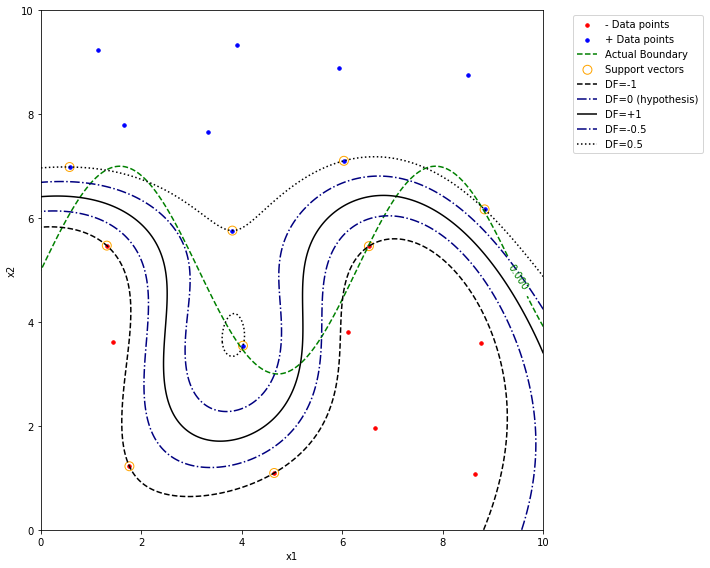

In [3]:
plotSpace(mySpace, 
        classifier=clf, 
        figsize = figSize, 
        meshRes=meshRes,
        legend = True, 
        showPlot=False,
        saveInfo = sInfo, 
        benchmark = myBench,
        extraLevels = [-0.5,0.5])

In [4]:
converger = GA_Convergence_Sampler(space = mySpace,
                    clf = clf,
                    batchSize = 1,
                    convergence_curve=False,
                    progress_bar=False)

In [5]:
sv, cp, label = converger.getFittingSupportVector()
print(sv, cp,label)

[1.76056666 1.22338088] [1.31076704 5.47164381] 0


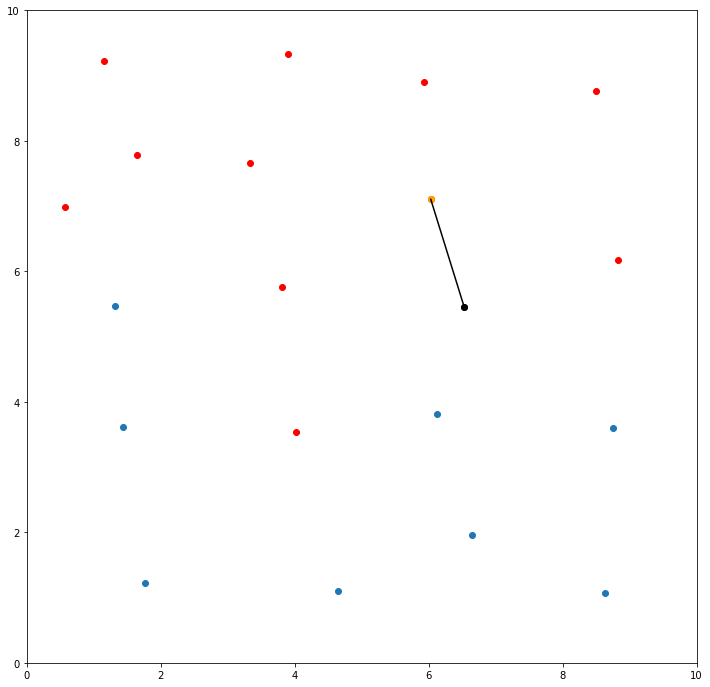

In [6]:
figSize = (12,12)
def minDistanceFromOppClass(space, point, label):
    opLabel = label ^ 1 
    ranges = space.getAllDimensionsRanges()
    labels = np.array(space._eval_labels)
    oppSamples = space.samples[labels==opLabel,:]
    distances = np.linalg.norm(np.divide(oppSamples-point, ranges), axis = 1)
    distInd = np.argmin(distances)
    closestSample = oppSamples[distInd, :]
    distance = distances[distInd]
    return distance, closestSample
def testMinDistance(svInd = 0):
    SVs = clf.getSupportVectors(standard = True)
    # svInd = 5
    label= clf.predict(SVs[svInd,:].reshape(1,2))
    dist, cs = minDistanceFromOppClass(mySpace, SVs[svInd,:],label)
    plt.figure(figsize = figSize)
    labels = np.array(mySpace._eval_labels)

    plt.scatter(mySpace.samples[labels==0,0], mySpace.samples[labels==0,1])
    plt.scatter(mySpace.samples[labels==1,0], mySpace.samples[labels==1,1], color = 'r')
    plt.scatter(SVs[svInd,0],SVs[svInd,1], color = 'black')
    plt.scatter(cs[0],cs[1], color = 'orange')

    xs = [SVs[svInd,0],cs[0]]
    ys = [SVs[svInd,1],cs[1]]
    plt.plot(xs,ys, color = 'k')


    plt.xlim([0,10])
    plt.ylim([0,10])
testMinDistance(2)

In [7]:
bestPoints = {} 
SVs = clf.getSupportVectors(standard = True)
labels = clf.predict(SVs)
maxDist = float('-inf')
candidSV, candidCp, candidLabel = None, None, None 
R = 0
for idx , sv in enumerate(SVs):
    label = labels[idx]
    svDist, svCp = minDistanceFromOppClass(mySpace, sv, label)
    if svDist > maxDist: 
        candidSv = sv 
        candidCp = svCp 
        R = svDist / 2 
        candidLabel = label 
        maxDist = svDist
# Now we have the SV and its closest point and the SV label and R.
print(candidSv, candidCp, candidLabel, R)
newPoint = (candidSv + candidCp) / 2 

f_hat = clf.decision_function(newPoint.reshape(1,2))


[0.56970905 6.98482756] [1.31076704 5.47164381] 1 0.08424505903744943


[-1, array([-0.2312467]), 0, 1] ['k', 'navy', 'k', 'k'] ['dashed', 'dashdot', 'solid', 'dotted']


(0, 10)

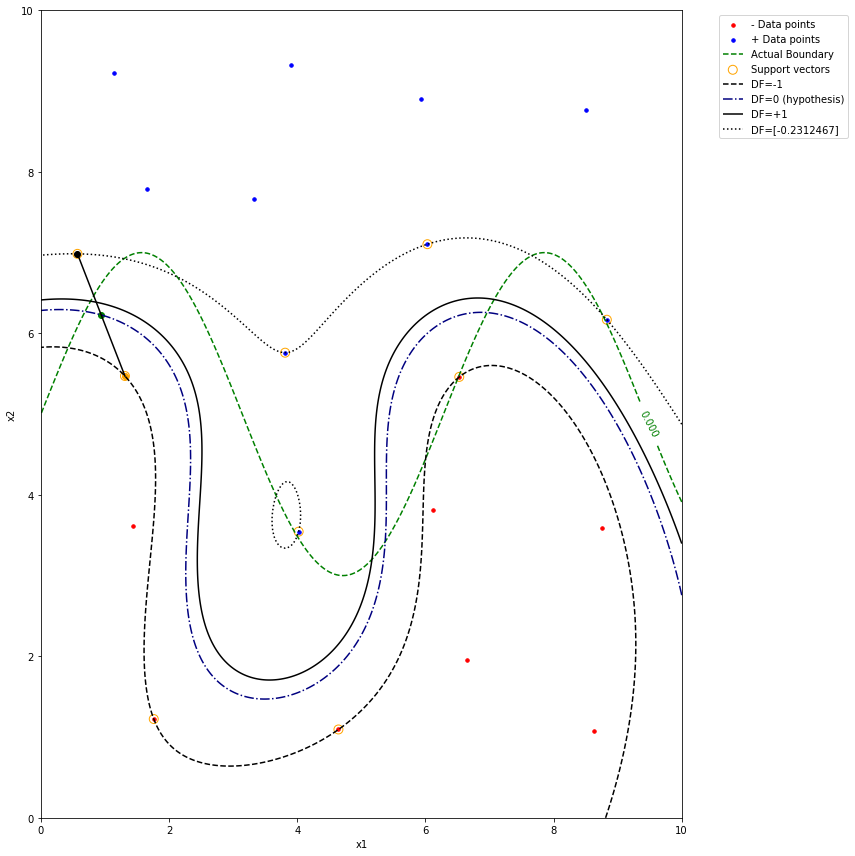

In [8]:

plotSpace(mySpace, 
        classifier=clf, 
        figsize = figSize, 
        meshRes=meshRes,
        legend = True, 
        showPlot=False,
        saveInfo = sInfo, 
        benchmark = myBench,
        extraLevels = [f_hat])

plt.scatter(candidSv[0],candidSv[1], color = 'black')
plt.scatter(candidCp[0],candidCp[1], color = 'orange')
plt.scatter(newPoint[0],newPoint[1], color = 'green')

xs = [candidSv[0],candidCp[0]]
ys = [candidSv[1],candidCp[1]]
plt.plot(xs,ys, color = 'k')
plt.xlim([0,10])
plt.ylim([0,10])



